In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import argparse
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

parser = argparse.ArgumentParser()

# parser.add_argument('directory', 
#                     type=str, 
#                     help = 'directory where files are stored')
# args = parser.parse_args()

# base_dir = '../data/Car Hacking Dataset/'
base_dir = './'


file_name = 'aux_attacks_new_new.csv'
data = pd.read_csv(os.path.join(base_dir, file_name))

# save_loc = os.path.join(base_dir, 'Adversarial Training Evaluation')
# os.makedirs(save_loc)

data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
data.drop(['Timestamp'], axis = 1, inplace = True)

def hex_to_bin(hex_num):
    
    binary_value = bin(int(str(hex_num), 16))[2:]
    
    return binary_value

def int_to_bin(int_num):
    
    binary_value = bin(int_num)[2:]
    
    return binary_value

def pad(value, length):
    
    curr_length = len(str(value))
    
    zeros = '0' * (length - curr_length)
    
    return zeros + value

hex_to_dec = lambda x: int(x, 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

def sequencify_data(X, y, seq_size=10):
    max_index = len(X) - seq_size + 1

    X_seq = []
    y_seq = []

    for i in range(0, max_index, seq_size):
        X_seq.append(X[i:i+seq_size])  # Append the sequence from DataFrame 'X'
        y_seq.append(1 if 1 in y[i:i+seq_size] else 0)  # Check for '1' in 'y' values

    return np.array(X_seq), np.array(y_seq)

# data = transform_data(data)

In [5]:
X = data.drop('label', axis = 1)
X = pd.get_dummies(X, columns=['ID'], prefix='ID')
y = data['label']

In [9]:
len(X.columns)

30

In [4]:
X.head()

,ID,DLC,Payload,IAT
0,848.0,8.0,3.716925e+17,0.000000
1,704.0,8.0,1.441152e+18,0.000221
2,1072.0,8.0,0.000000e+00,0.000554
3,1201.0,8.0,0.000000e+00,0.000238
4,497.0,8.0,0.000000e+00,0.000248


In [7]:
y_tri = y.copy(deep=True)
y = y.replace(2,1)

In [4]:
print(np.unique(y_tri, return_counts=True))
print(np.unique(y, return_counts=True))

(array([0., 1., 2.]), array([100000,  18191,  33883]))
(array([0., 1.]), array([100000,  52074]))


In [8]:
X_seq, y_seq = sequencify_data(X.values, y.values)

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size = 0.2, shuffle= True)

#Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

seq_scaler = StandardScaler()
num_train_samples, seq_length, num_features = X_seq_train.shape
num_test_samples, _, _ = X_seq_test.shape

X_train_seq_reshaped = X_seq_train.reshape(num_train_samples, -1)
X_test_seq_reshaped = X_seq_test.reshape(num_test_samples, -1)

X_train_seq_scaled = seq_scaler.fit_transform(X_train_seq_reshaped)
X_test_seq_scaled = seq_scaler.transform(X_test_seq_reshaped)

# Reshape the scaled data back to the original shape
X_seq_train = X_train_seq_scaled.reshape(num_train_samples, seq_length, num_features)
X_seq_test = X_test_seq_scaled.reshape(num_test_samples, seq_length, num_features)

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train) 

In [10]:
##Models

print("-----MLP-------")

mlp = Sequential()
mlp.add(Input(shape = (30)))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(1, activation = 'sigmoid'))

mlp.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

mlp_hist = mlp.fit(X_train_smote, y_train_smote, epochs=100, callbacks = [es], validation_split=0.2, batch_size = 128)

##MLP
print("-----MLP-------")

threshold = 0.5
mlp_preds = mlp.predict(X_test)
mlp_preds = (mlp_preds >= threshold).astype(int)

print("ACCURACY: ", accuracy_score(y_test, mlp_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, mlp_preds))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'w') as file:
#     file.write("-------MLP-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, mlp_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, mlp_preds)))
#     file.write("\n\n\n\n")

# mlp.save(os.path.join(save_loc, 'mlp.h5'))

# plt.figure(figsize=(10, 10))
# plt.plot(mlp_hist.history['loss'])
# plt.plot(mlp_hist.history['val_loss'])
# plt.title('MLP Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig(os.path.join(save_loc,'mlp_training_history.png'))

-----MLP-------
Metal device set to: 

2024-09-13 01:23:06.369917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 01:23:06.370848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/100


2024-09-13 01:23:07.119658: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-09-13 01:23:07.392684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1001/1001 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.7139

2024-09-13 01:23:14.597469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1001/1001 [==============================] - 9s 6ms/step - loss: 0.5487 - accuracy: 0.7139 - val_loss: 0.8174 - val_accuracy: 0.5069
Epoch 2/100
1001/1001 [==============================] - 5s 5ms/step - loss: 0.5307 - accuracy: 0.7267 - val_loss: 0.7359 - val_accuracy: 0.5433
Epoch 3/100
1001/1001 [==============================] - 5s 5ms/step - loss: 0.5252 - accuracy: 0.7303 - val_loss: 0.7624 - val_accuracy: 0.5161
Epoch 4/100
1001/1001 [==============================] - 4s 4ms/step - loss: 0.5200 - accuracy: 0.7344 - val_loss: 0.7553 - val_accuracy: 0.5179
Epoch 5/100
1001/1001 [==============================] - 4s 4ms/step - loss: 0.5152 - accuracy: 0.7386 - val_loss: 0.7373 - val_accuracy: 0.5664
Epoch 6/100
1001/1001 [==============================] - 4s 4ms/step - loss: 0.5096 - accuracy: 0.7445 - val_loss: 0.7349 - val_accuracy: 0.5142
Epoch 7/100
1001/1001 [==============================] - 4s 4ms/step - loss: 0.5029 - accuracy: 0.7497 - val_loss: 0.6700 - val_accuracy: 0.58

2024-09-13 01:24:27.955822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


951/951 [==============================] - 2s 2ms/step
ACCURACY:  0.7661022521782015
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.81      0.84      0.82     19990
         1.0       0.67      0.63      0.65     10425

    accuracy                           0.77     30415
   macro avg       0.74      0.73      0.74     30415
weighted avg       0.76      0.77      0.76     30415



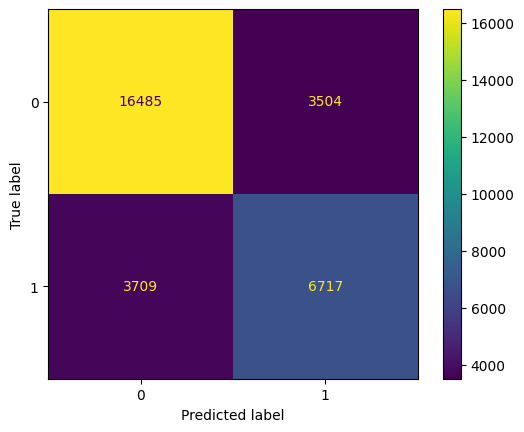

In [7]:
cm = confusion_matrix(y_test, mlp_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()

In [ ]:
##LSTM

print("-----LSTM-------")

lstm = Sequential()

lstm.add(Input(shape = X_seq_train.shape[1:]))
lstm.add(LSTM(128, activation = 'relu'))
lstm.add(Dense(1, activation = 'sigmoid'))

lstm.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

lstm_hist = lstm.fit(X_seq_train, y_seq_train, batch_size = 16, validation_split = 0.2,
        callbacks = [es], epochs = 1000)

print("-----LSTM-------")

lstm_preds = lstm.predict(X_seq_test, batch_size=4096)
lstm_preds = (lstm_preds >= threshold).astype(int)

print("ACCURACY: ", accuracy_score(y_seq_test, lstm_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_seq_test, lstm_preds))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------LSTM-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_seq_test, lstm_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_seq_test, lstm_preds)))
#     file.write("\n\n\n\n")

# lstm.save(os.path.join(save_loc, 'lstm.h5'))

# plt.figure(figsize=(10, 10))
# plt.plot(lstm_hist.history['loss'])
# plt.plot(lstm_hist.history['val_loss'])
# plt.title('LSTM Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig(os.path.join(save_loc,'lstm_training_history.png'))

-----LSTM-------
Epoch 1/1000


2024-09-05 02:18:12.683157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


: 

In [8]:
## XGBOOST
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)
xgb_preds = xgb.predict(X_test)

print("-------XGBOOST-------")
print("ACCURACY: ", accuracy_score(y_test, xgb_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, xgb_preds))
# xgb.save_model(os.path.join(save_loc, 'xgb.json'))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------XGB-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, xgb_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, xgb_preds)))
#     file.write("\n\n\n\n")

## DECISION TREE
dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train_smote, y_train_smote)
dt_preds = dt.predict(X_test)

print("-------DECISION TREE--------")
print("ACCURACY: ", accuracy_score(y_test, dt_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, dt_preds))
# dump(dt, os.path.join(save_loc, 'dt.pkl'))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------Decision Tree-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, dt_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, dt_preds)))
#     file.write("\n\n\n\n")

## RANDOM FOREST

rf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf.fit(X_train_smote, y_train_smote)
rf_preds = rf.predict(X_test)

print("-------RANDOM FOREST-------\n")
print("ACCURACY: ", accuracy_score(y_test, rf_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, rf_preds))
# dump(rf, os.path.join(save_loc, 'rf.pkl'))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------Random Forest-------")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, rf_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, rf_preds)))
#     file.write("\n\n\n\n")

-------XGBOOST-------
ACCURACY:  0.8563866513233602
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.93      0.84      0.88     19989
         1.0       0.74      0.89      0.81     10426

    accuracy                           0.86     30415
   macro avg       0.84      0.86      0.85     30415
weighted avg       0.87      0.86      0.86     30415

-------DECISION TREE--------
ACCURACY:  0.6878185106033208
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.84      0.65      0.73     19989
         1.0       0.53      0.77      0.63     10426

    accuracy                           0.69     30415
   macro avg       0.69      0.71      0.68     30415
weighted avg       0.74      0.69      0.70     30415

-------RANDOM FOREST-------

ACCURACY:  0.729903008384021
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.86      0.71      0.77     19

In [50]:
X_scaled = scaler.transform(X)
dt_preds_full = dt.predict(X_scaled)

In [51]:
X['Label'] = y
X['Preds'] = dt_preds_full
X["Packet Type"] = y_tri
X["Packet Type"].replace({0 : "Benign", 1 : "Main Attack Packet", 2 : "Auxillary Attack Packet"})
X["IAT"] = X["IAT"] * 1e6

In [53]:
X.to_csv('aux_attack_result.csv')

DT


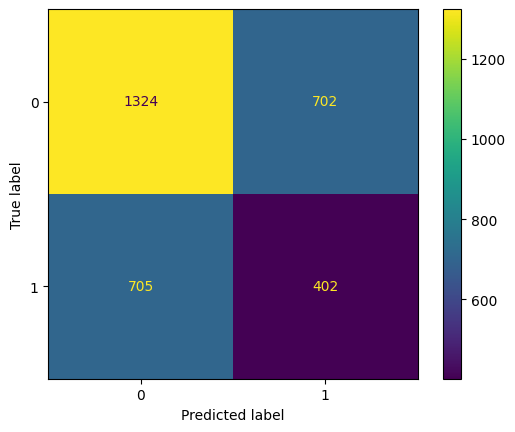

In [12]:
print("DT")
cm = confusion_matrix(y_test, dt_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()

RF


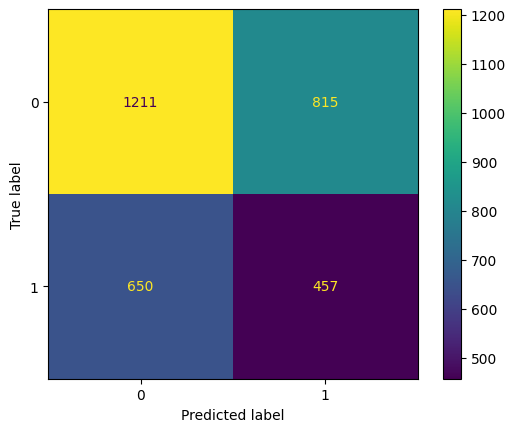

In [13]:
print("RF")
cm = confusion_matrix(y_test, rf_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()

In [27]:
X_transform = scaler.transform(X)

In [28]:
preds = (mlp.predict(X_transform) >= 0.5).astype(int)

  23/3860 [..............................] - ETA: 8s   

2024-09-05 13:15:13.990318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3860/3860 [==============================] - 5s 1ms/step


In [31]:
preds.shape

(123518, 1)

In [33]:
dec_to_hex = lambda x : hex(int(x))[2:]

In [40]:
X['Label'] = y
X['Predicted'] = preds
X['IAT'] = X['IAT'] * 1e6 
X['ID_HEX'] = X['ID'].apply(dec_to_hex)

In [41]:
X

,ID,DLC,Payload,IAT,Label,Predicted,ID_HEX
0,848.0,8.0,3.716925e+17,0.000000e+00,0.0,0,350
1,704.0,8.0,1.441152e+18,2.210140e+26,0.0,0,2c0
2,1072.0,8.0,0.000000e+00,5.538464e+26,0.0,1,430
3,1201.0,8.0,0.000000e+00,2.379417e+26,0.0,0,4b1
4,497.0,8.0,0.000000e+00,2.481937e+26,0.0,0,1f1
...,...,...,...,...,...,...,...
123513,608.0,8.0,3.202177e+18,2.379417e+26,0.0,0,260
123514,672.0,8.0,1.177723e+14,2.360344e+26,0.0,0,2a0
123515,809.0,8.0,9.779705e+18,2.300739e+26,0.0,0,329
123516,880.0,8.0,9.851624e+15,2.470016e+26,0.0,0,370


In [37]:
dec_to_hex(848.0)

'350'

In [45]:
X['IAT'].iloc[1:]

1         2.210140e+26
2         5.538464e+26
3         2.379417e+26
4         2.481937e+26
5         2.479553e+26
              ...     
123513    2.379417e+26
123514    2.360344e+26
123515    2.300739e+26
123516    2.470016e+26
123517    2.369881e+26
Name: IAT, Length: 123517, dtype: float64